In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
import seaborn as sn
from fast_histogram import histogram2d

In [8]:
#data_path = "/disk/atlas3/data_MC/ATLASOpen/jets/part1.root" 
ttbar_data_path = "/disk/atlas3/data_MC/delphes/ttbar_13TeV_taus_10000events.root:Delphes" 
directW_data_path = "/disk/atlas3/data_MC/delphes/directW_13TeV_taus_10000events.root:Delphes" 
#data_path = "../../Delphes-3.5.0/directW_13TeV.root:Delphes" 

These are some examples of how to look at root files using uproot and awkward arrays. More info in this tutorial:
https://hub.gke2.mybinder.org/user/jpivarski-2020--ep2020-tutorial-7h7oraqf/lab/tree/tutorial.ipynb


In [9]:
def cal_image_plot(ax):
    """
    Formating of calorimeter image
    """
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    #ax.set_title("Calorimeter image", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

def zero_to_nan(arr):
    """
    converts the zeros to NaN to avoid confusion
    """
    clusters = arr.clusters
    clusters.E = ak.where(clusters.E == 0, np.nan, clusters.E)
    clusters.x = ak.where(clusters.x == 0, np.nan, clusters.x)
    clusters.y = ak.where(clusters.y == 0, np.nan, clusters.y)
    clusters.z = ak.where(clusters.z == 0, np.nan, clusters.z)
    arr.clusters = clusters
    return arr

def cartesian_to_angles(arr, drop:bool=False):
    """
    converts cartesian coordinates to polar angles
    """
    clusters = arr.clusters
    clusters["pT"] = np.sqrt(clusters.x**2 + clusters.y**2)
    clusters["eta"] = np.arcsinh(clusters.z/clusters["pT"])
    clusters["phi"] = np.arcsin(clusters.y/clusters["pT"])
    """
    Add this functionality: drop old values
    if drop:
    """
    arr.clusters = clusters
    return arr

In [10]:
#Open file in with-function will close it when you exit
def look(rootfile:str):
    with uproot.open(rootfile) as file:
        keys = file.keys()
        #print(keys)
        #print(file.show())
        print(file["Tower"].keys())
        #print(file["Tower"]["Tower.ET"].array())

def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")


#look(data_path)
ttbar_clusters = load_data(ttbar_data_path, "Tower", ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])
directW_clusters = load_data(directW_data_path, "Tower", ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])
#print(ak.to_list(clusters[0]))
max_hits = np.max([len(item) for item in ttbar_clusters["ET"]])
print(max_hits)
ttbar_clusters = ak.pad_none(ttbar_clusters, max_hits, axis=-1)
directW_clusters = ak.pad_none(directW_clusters, max_hits, axis=-1)

526


In [11]:
#clusters["EZ"] = clusters["ET"]*np.sinh(clusters["Eta"])
#clusters["EX"] = clusters["ET"]*np.cos(clusters["Phi"])
#clusters["EY"] = clusters["ET"]*np.sin(clusters["Phi"])

In [12]:
#Extracting data for plotting
ttbar_largest_ET = ak.argmax(ttbar_clusters.ET, axis=-1, keepdims=True)
ttbar_eta = ak.to_list(ak.flatten(ttbar_clusters.Eta[ttbar_largest_ET]))
ttbar_phi = ak.to_list(ak.flatten(ttbar_clusters.Phi[ttbar_largest_ET]))
ttbar_ET = ak.to_list(ak.flatten(ttbar_clusters.ET[ttbar_largest_ET]))

directW_largest_ET = ak.argmax(directW_clusters.ET, axis=-1, keepdims=True)
directW_eta = ak.to_list(ak.flatten(directW_clusters.Eta[directW_largest_ET]))
directW_phi = ak.to_list(ak.flatten(directW_clusters.Phi[directW_largest_ET]))
directW_ET = ak.to_list(ak.flatten(directW_clusters.ET[directW_largest_ET]))

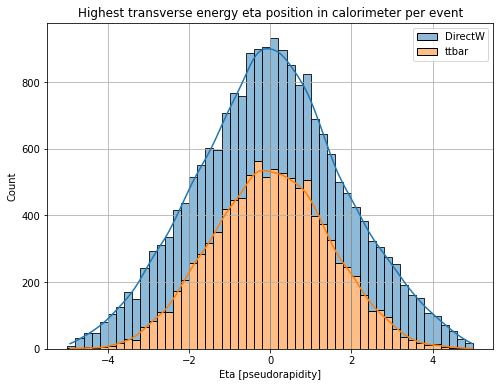

In [13]:
#Eta distribution
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"DirectW": directW_eta, "ttbar": ttbar_eta}, ax = ax, bins=50, binrange=[-5,5], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy eta position in calorimeter per event")
ax.set_xlabel("Eta [pseudorapidity]")
#ax.set_yscale('log')
ax.grid(visible=None)

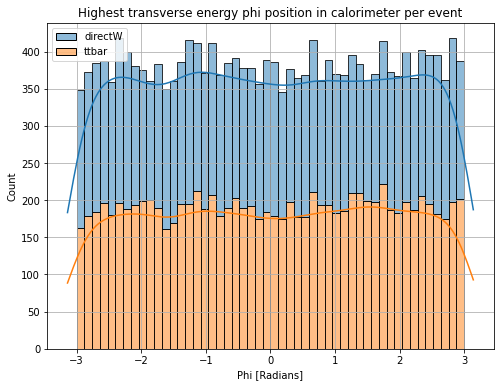

In [14]:
#Phi distribution, should be uniform
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"directW": directW_phi, "ttbar": ttbar_phi}, ax = ax, bins=50, binrange=[-3,3], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy phi position in calorimeter per event")
ax.set_xlabel("Phi [Radians]")
#ax.set_yscale('log')
ax.grid(visible=None)

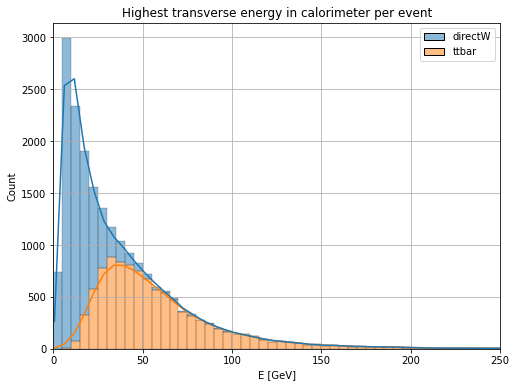

In [15]:
#Energy distribution
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"directW": directW_ET, "ttbar": ttbar_ET}, ax = ax, bins=50, binrange=[0,250], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy in calorimeter per event")
ax.set_xlabel("E [GeV]")
ax.set_xlim(0, 250)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.grid(visible=None)

In [16]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-5, 5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
    #Cal = [histogram2d(event.phi, event.eta, range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION) for event in array[:max_events]]
    return Cal


hists = create_histograms(ak.to_numpy(directW_clusters.Phi), ak.to_numpy(directW_clusters.Eta), ak.to_numpy(directW_clusters.ET))

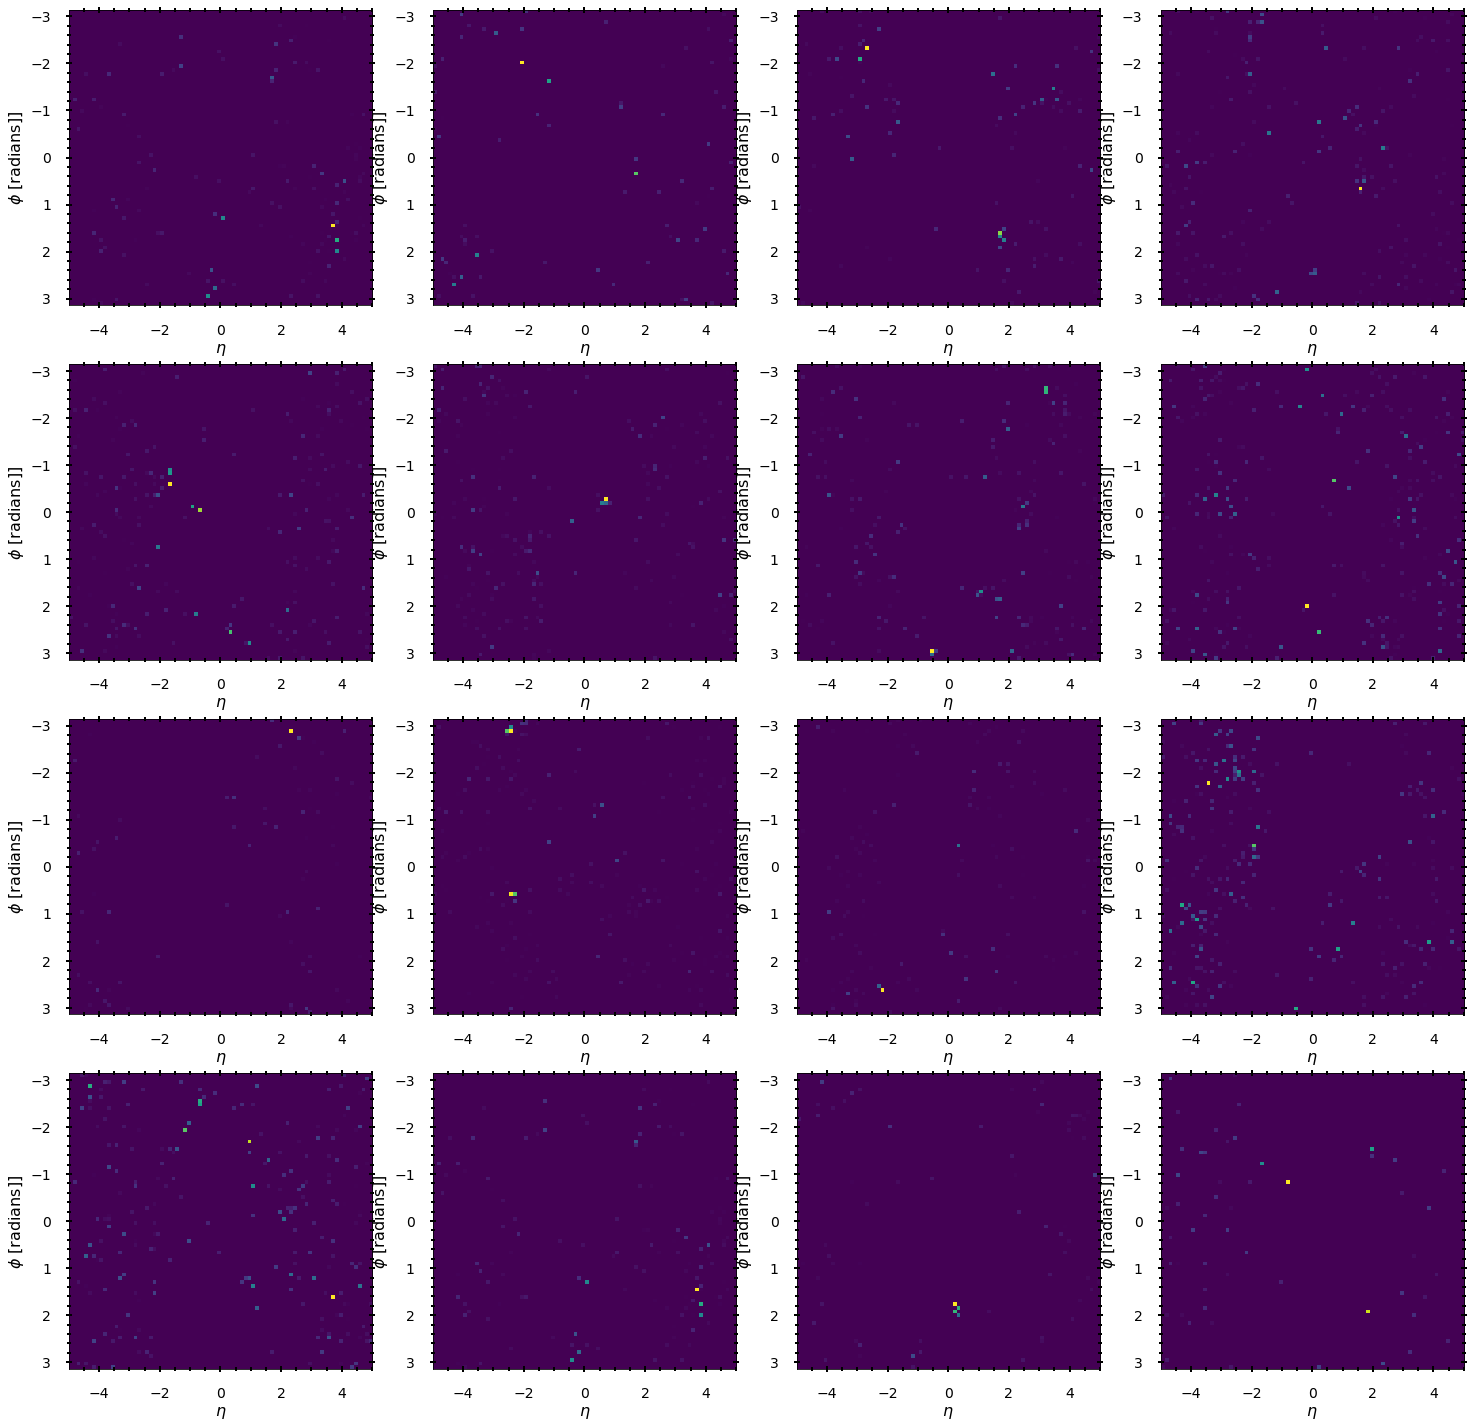

In [17]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-5, 5, np.pi, -np.pi], aspect='auto')

In [18]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-5, 5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
            
    return Cal


hists = create_histograms(ak.to_numpy(ttbar_clusters.Phi), ak.to_numpy(ttbar_clusters.Eta), ak.to_numpy(ttbar_clusters.ET))

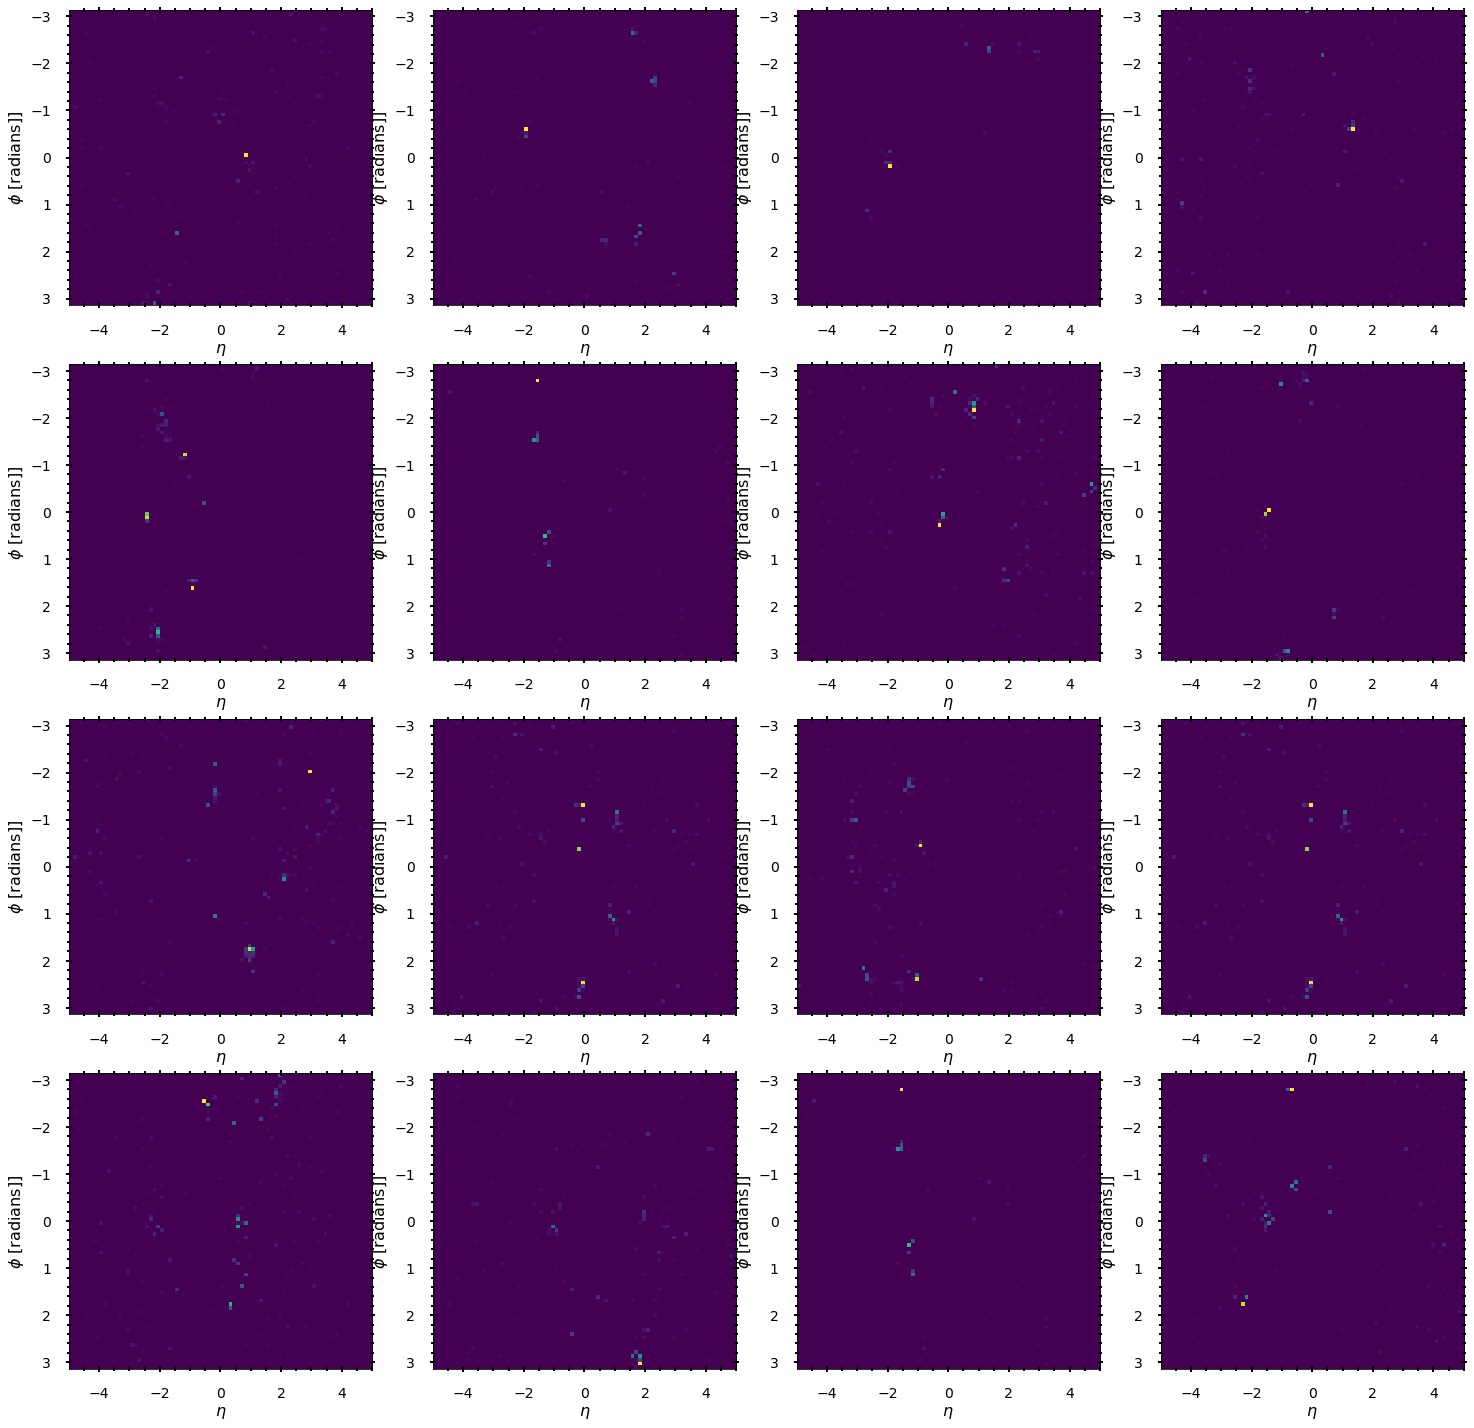

In [19]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-5, 5, np.pi, -np.pi], aspect='auto')

Text(0.5, 0, 'Tower transverse energy')

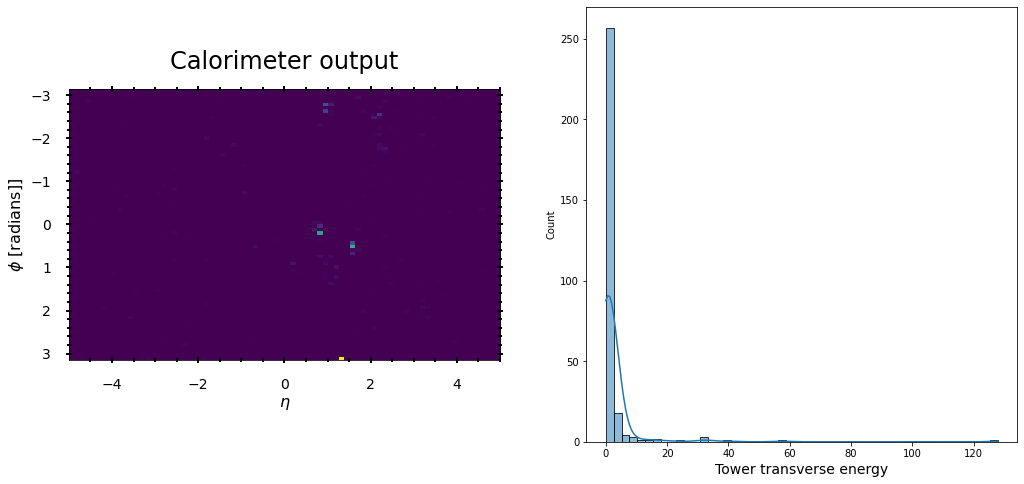

In [20]:
k = 2 #np.random.randint(0, high=len(hists)) #a random image
ET = ak.to_list(ttbar_clusters.ET[k])
def cal_image_plot(ax):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    ax.set_title("Calorimeter output", fontsize=24, color="black", pad=20)
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 8))
cal_image_plot(axs[0])
axs[0].imshow(hists[k], extent=[-5, 5, np.pi, -np.pi], aspect='equal')
sn.histplot(ET, ax = axs[1], bins=50, kde=True, stat="count")
axs[1].set_xlabel("Tower transverse energy", fontsize=14)

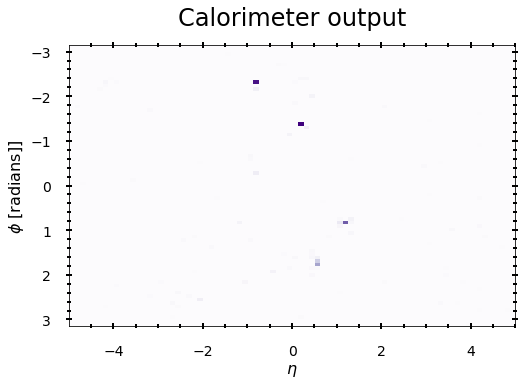

In [44]:
k = 59 #np.random.randint(0, high=len(hists)) #a random image
ET = ak.to_list(ttbar_clusters.ET[k])

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
cal_image_plot(axs)
axs.imshow(hists[k], cmap='Purples', extent=[-5, 5, np.pi, -np.pi], aspect='equal')

In [41]:
event = ttbar_clusters[k]
print(ak.sort(ttbar_clusters.ET[k], ascending=False))
index = ak.argsort(event.ET, ascending=False, axis=-1)[0:20]
print(index)
eta = ak.to_list(event.Eta[index])
phi = ak.to_list(event.Phi[index])
ET = ak.to_list(event.ET[index])
df = pd.DataFrame({"Eta": eta, "Phi": phi, "Energy": ET})
print(df)

[49.2, 46.1, 22.8, 14.6, 12.4, 8.65, 7.53, ... None, None, None, None, None, None]
[85, 81, 89, 88, 91, 47, 48, 44, 83, 78, 82, 90, 86, 94, 84, 87, 80, 28, 49, 50]
         Eta       Phi     Energy
0   0.130362 -1.345472  49.159756
1  -0.872119 -2.344027  46.147343
2   0.532330  1.800708  22.793520
3   0.515110  1.721974  14.600808
4   1.177956  0.863215  12.353676
5   1.137336  0.858042   8.651063
6   1.177813  0.793448   7.530644
7   1.098756  0.794525   7.169203
8  -0.854335 -0.273384   5.876600
9  -2.021086  2.568536   5.641028
10 -0.801856 -2.133298   4.894080
11  0.603582  1.606446   4.890471
12  0.268909 -1.307210   4.712491
13  1.318933  0.742924   3.991169
14 -0.476248  1.892172   3.717618
15  0.446626 -2.036054   3.641954
16 -1.147193  0.791442   3.617770
17 -0.042251 -1.149096   3.532160
18  1.187030  0.793790   3.079843
19  1.193035  0.828713   2.467329


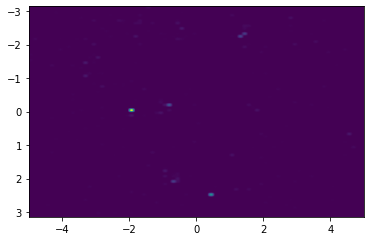

In [28]:
test = histogram2d(ak.to_numpy(event.Phi), ak.to_numpy(event.Eta), 
                    range=[[-np.pi, np.pi], [-5, 5]], bins=80, 
                    weights=ak.to_numpy(event.ET))
plt.imshow(test, extent=[-5, 5, np.pi, -np.pi])

In [24]:
print(test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
